In [10]:
!pip install tensorflow keras_cv --upgrade --quiet
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 16.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 20 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (70.7 MB/s)
(Reading database ... 128275 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128242 file

In [11]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image
from IPython.display import Image as IImage
from google.colab import files
import pandas as pd

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True, img_width=640)

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [12]:
seed = 12345
noise = tf.random.normal((512 // 8, 640 // 8, 4), seed=seed)

In [4]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [8]:
prompts_df = pd.read_csv('prompts.csv', index_col=0)
print(prompts_df.shape)
prompts_df.tail()

(48, 7)


,lyrics,description,timestamp_start,timestamp_end,start,end,prompt
43,"Nothing really matters, anyone can see","A person standing on a mountaintop, looking ou...",5:13,5:20,313,320,"A person standing on a mountaintop, looking ou..."
44,Nothing really matters,"A person sitting on a bench in a park, watchin...",5:20,5:24,320,324,"A person sitting on a bench in a park, watchin..."
45,Nothing really matters to me,"A person lying in bed, staring up at the ceili...",5:24,5:33,324,333,"A person lying in bed, staring up at the ceili..."
46,[Piano],A person playing the piano on stage,5:33,5:44,333,344,"A person playing the piano on stage, Lisa Fran..."
47,Any way the wind blows,"A person standing on a cliff, with their hair ...",5:44,5:59,344,359,"A person standing on a cliff, with their hair ..."


In [13]:
prompt_encodings = []
prompts_all = prompts_df.prompt.to_list()
for prompt in prompts_all:
  encoding = tf.squeeze(model.encode_text(prompt))
  prompt_encodings.append(encoding)

492466864/492466864 [==============================] - 5s 0us/step


In [ ]:
durations = 0
for i in range(prompts_df.shape[0]-1):
  x0 = prompts_df.iloc[i]
  x1 = prompts_df.iloc[i+1]
  durations += x0.end - x0.start + 1
durations

343

In [ ]:
fps = 3
all_interpolated_encodings = []

for i in range(prompts_df.shape[0]-1):
  x0 = prompts_df.iloc[i]
  x1 = prompts_df.iloc[i+1]
  duration = x0.end - x0.start + 1
  interpolation_steps = duration * fps
  interpolated_encodings = tf.linspace(prompt_encodings[i], prompt_encodings[i+1], interpolation_steps)
  all_interpolated_encodings.append(interpolated_encodings)

In [ ]:
interpolated_encodings_stack = tf.concat(all_interpolated_encodings, axis=0)

In [ ]:
interpolated_encodings_stack.shape

TensorShape([1170, 77, 768])

In [ ]:
num_steps = 15
batch_size = 5
batches = interpolated_encodings_stack.shape[0] // batch_size
batched_encodings = tf.split(interpolated_encodings_stack, batches)
batches

234

In [ ]:
images = []

In [ ]:
# 70 - 79
for batch in range(10):
  offset = 7
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 70


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198180272/198180272 [==============================] - 2s 0us/step
Saving image: 350
Saving image: 351
Saving image: 352
Saving image: 353
Saving image: 354

Batch: 71
16/16 [==============================] - 21s 1s/step
Saving image: 355
Saving image: 356
Saving image: 357
Saving image: 358
Saving image: 359

Batch: 72
16/16 [==============================] - 23s 1s/step
Saving image: 360
Saving image: 361
Saving image: 362
Saving image: 363
Saving image: 364

Batch: 73
16/16 [==============================] - 20s 1s/step
Saving image: 365
Saving image: 366
Saving image: 367
Saving image: 368
Saving image: 369

Batch: 74
16/16 [==============================] - 20s 1s/step
Saving image: 370
Saving image: 371
Saving image: 372
Saving image: 373
Saving image: 374

Batch: 75
16/16 [==============================] - 20s 1s/step
Saving image: 375
Saving image: 376
Saving image: 377
Saving image: 378
Saving image: 379

Batch: 76
16/16 [==============================] - 21s 1s/step
Saving im

In [ ]:
# 80 - 89
for batch in range(10):
  offset = 8
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 80
16/16 [==============================] - 21s 1s/step
Saving image: 400
Saving image: 401
Saving image: 402
Saving image: 403
Saving image: 404

Batch: 81
16/16 [==============================] - 20s 1s/step
Saving image: 405
Saving image: 406
Saving image: 407
Saving image: 408
Saving image: 409

Batch: 82
16/16 [==============================] - 20s 1s/step
Saving image: 410
Saving image: 411
Saving image: 412
Saving image: 413
Saving image: 414

Batch: 83
16/16 [==============================] - 21s 1s/step
Saving image: 415
Saving image: 416
Saving image: 417
Saving image: 418
Saving image: 419

Batch: 84
16/16 [==============================] - 20s 1s/step
Saving image: 420
Saving image: 421
Saving image: 422
Saving image: 423
Saving image: 424

Batch: 85
16/16 [==============================] - 20s 1s/step
Saving image: 425
Saving image: 426
Saving image: 427
Saving image: 428
Saving image: 429

Batch: 86
16/16 [==============================] - 20s 1s/step
Saving image

In [ ]:
# 90 - 99
for batch in range(10):
  offset = 9
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 90
16/16 [==============================] - 20s 1s/step
Saving image: 450
Saving image: 451
Saving image: 452
Saving image: 453
Saving image: 454

Batch: 91
16/16 [==============================] - 20s 1s/step
Saving image: 455
Saving image: 456
Saving image: 457
Saving image: 458
Saving image: 459

Batch: 92
16/16 [==============================] - 20s 1s/step
Saving image: 460
Saving image: 461
Saving image: 462
Saving image: 463
Saving image: 464

Batch: 93
16/16 [==============================] - 20s 1s/step
Saving image: 465
Saving image: 466
Saving image: 467
Saving image: 468
Saving image: 469

Batch: 94
16/16 [==============================] - 20s 1s/step
Saving image: 470
Saving image: 471
Saving image: 472
Saving image: 473
Saving image: 474

Batch: 95
16/16 [==============================] - 21s 1s/step
Saving image: 475
Saving image: 476
Saving image: 477
Saving image: 478
Saving image: 479

Batch: 96
16/16 [==============================] - 20s 1s/step
Saving image

In [ ]:
# 100 - 109
for batch in range(10):
  offset = 10
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 100
16/16 [==============================] - 20s 1s/step
Saving image: 500
Saving image: 501
Saving image: 502
Saving image: 503
Saving image: 504

Batch: 101
16/16 [==============================] - 20s 1s/step
Saving image: 505
Saving image: 506
Saving image: 507
Saving image: 508
Saving image: 509

Batch: 102
16/16 [==============================] - 20s 1s/step
Saving image: 510
Saving image: 511
Saving image: 512
Saving image: 513
Saving image: 514

Batch: 103
16/16 [==============================] - 20s 1s/step
Saving image: 515
Saving image: 516
Saving image: 517
Saving image: 518
Saving image: 519

Batch: 104
16/16 [==============================] - 20s 1s/step
Saving image: 520
Saving image: 521
Saving image: 522
Saving image: 523
Saving image: 524

Batch: 105
16/16 [==============================] - 20s 1s/step
Saving image: 525
Saving image: 526
Saving image: 527
Saving image: 528
Saving image: 529

Batch: 106
16/16 [==============================] - 21s 1s/step
Savin

In [ ]:
for i in range(530, 550):
  files.download(f'img_{i}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 110 - 119
for batch in range(10):
  offset = 11
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 110
16/16 [==============================] - 20s 1s/step
Saving image: 550
Saving image: 551
Saving image: 552
Saving image: 553
Saving image: 554

Batch: 111
16/16 [==============================] - 24s 1s/step
Saving image: 555
Saving image: 556
Saving image: 557
Saving image: 558
Saving image: 559

Batch: 112
16/16 [==============================] - 20s 1s/step
Saving image: 560
Saving image: 561
Saving image: 562
Saving image: 563
Saving image: 564

Batch: 113
16/16 [==============================] - 20s 1s/step
Saving image: 565
Saving image: 566
Saving image: 567
Saving image: 568
Saving image: 569

Batch: 114
16/16 [==============================] - 20s 1s/step
Saving image: 570
Saving image: 571
Saving image: 572
Saving image: 573
Saving image: 574

Batch: 115
16/16 [==============================] - 21s 1s/step
Saving image: 575
Saving image: 576
Saving image: 577
Saving image: 578
Saving image: 579

Batch: 116
16/16 [==============================] - 20s 1s/step
Savin

In [ ]:
# 120 - 129
for batch in range(10):
  offset = 12
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 120
16/16 [==============================] - 22s 1s/step
Saving image: 600
Saving image: 601
Saving image: 602
Saving image: 603
Saving image: 604

Batch: 121
16/16 [==============================] - 21s 1s/step
Saving image: 605
Saving image: 606
Saving image: 607
Saving image: 608
Saving image: 609

Batch: 122
16/16 [==============================] - 20s 1s/step
Saving image: 610
Saving image: 611
Saving image: 612
Saving image: 613
Saving image: 614

Batch: 123
16/16 [==============================] - 20s 1s/step
Saving image: 615
Saving image: 616
Saving image: 617
Saving image: 618
Saving image: 619

Batch: 124
16/16 [==============================] - 21s 1s/step
Saving image: 620
Saving image: 621
Saving image: 622
Saving image: 623
Saving image: 624

Batch: 125
16/16 [==============================] - 21s 1s/step
Saving image: 625
Saving image: 626
Saving image: 627
Saving image: 628
Saving image: 629

Batch: 126
16/16 [==============================] - 21s 1s/step
Savin

In [ ]:
# 130 - 139
for batch in range(10):
  offset = 13
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 130
16/16 [==============================] - 20s 1s/step
Saving image: 650
Saving image: 651
Saving image: 652
Saving image: 653
Saving image: 654

Batch: 131
16/16 [==============================] - 20s 1s/step
Saving image: 655
Saving image: 656
Saving image: 657
Saving image: 658
Saving image: 659

Batch: 132
16/16 [==============================] - 21s 1s/step
Saving image: 660
Saving image: 661
Saving image: 662
Saving image: 663
Saving image: 664

Batch: 133
16/16 [==============================] - 20s 1s/step
Saving image: 665
Saving image: 666
Saving image: 667
Saving image: 668
Saving image: 669

Batch: 134
16/16 [==============================] - 20s 1s/step
Saving image: 670
Saving image: 671
Saving image: 672
Saving image: 673
Saving image: 674

Batch: 135
16/16 [==============================] - 21s 1s/step
Saving image: 675
Saving image: 676
Saving image: 677
Saving image: 678
Saving image: 679

Batch: 136
16/16 [==============================] - 21s 1s/step
Savin

In [ ]:
# 140 - 149
for batch in range(10):
  offset = 14
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 140
16/16 [==============================] - 20s 1s/step
Saving image: 700
Saving image: 701
Saving image: 702
Saving image: 703
Saving image: 704

Batch: 141
16/16 [==============================] - 21s 1s/step
Saving image: 705
Saving image: 706
Saving image: 707
Saving image: 708
Saving image: 709

Batch: 142
16/16 [==============================] - 21s 1s/step
Saving image: 710
Saving image: 711
Saving image: 712
Saving image: 713
Saving image: 714

Batch: 143
16/16 [==============================] - 21s 1s/step
Saving image: 715
Saving image: 716
Saving image: 717
Saving image: 718
Saving image: 719

Batch: 144
16/16 [==============================] - 20s 1s/step
Saving image: 720
Saving image: 721
Saving image: 722
Saving image: 723
Saving image: 724

Batch: 145
16/16 [==============================] - 20s 1s/step
Saving image: 725
Saving image: 726
Saving image: 727
Saving image: 728
Saving image: 729

Batch: 146
16/16 [==============================] - 20s 1s/step
Savin

In [ ]:
for i in range(743, 750):
  files.download(f'img_{i}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 150 - 159
for batch in range(10):
  offset = 15
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 150
16/16 [==============================] - 21s 1s/step
Saving image: 750
Saving image: 751
Saving image: 752
Saving image: 753
Saving image: 754

Batch: 151
16/16 [==============================] - 21s 1s/step
Saving image: 755
Saving image: 756
Saving image: 757
Saving image: 758
Saving image: 759

Batch: 152
16/16 [==============================] - 21s 1s/step
Saving image: 760
Saving image: 761
Saving image: 762
Saving image: 763
Saving image: 764

Batch: 153
16/16 [==============================] - 20s 1s/step
Saving image: 765
Saving image: 766
Saving image: 767
Saving image: 768
Saving image: 769

Batch: 154
16/16 [==============================] - 20s 1s/step
Saving image: 770
Saving image: 771
Saving image: 772
Saving image: 773
Saving image: 774

Batch: 155
16/16 [==============================] - 21s 1s/step
Saving image: 775
Saving image: 776
Saving image: 777
Saving image: 778
Saving image: 779

Batch: 156
16/16 [==============================] - 20s 1s/step
Savin

In [ ]:
# 160 - 169
for batch in range(10):
  offset = 16
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 160
16/16 [==============================] - 20s 1s/step
Saving image: 800
Saving image: 801
Saving image: 802
Saving image: 803
Saving image: 804

Batch: 161
16/16 [==============================] - 20s 1s/step
Saving image: 805
Saving image: 806
Saving image: 807
Saving image: 808
Saving image: 809

Batch: 162
16/16 [==============================] - 20s 1s/step
Saving image: 810
Saving image: 811
Saving image: 812
Saving image: 813
Saving image: 814

Batch: 163
16/16 [==============================] - 20s 1s/step
Saving image: 815
Saving image: 816
Saving image: 817
Saving image: 818
Saving image: 819

Batch: 164
16/16 [==============================] - 20s 1s/step
Saving image: 820
Saving image: 821
Saving image: 822
Saving image: 823
Saving image: 824

Batch: 165
16/16 [==============================] - 20s 1s/step
Saving image: 825
Saving image: 826
Saving image: 827
Saving image: 828
Saving image: 829

Batch: 166
16/16 [==============================] - 20s 1s/step
Savin

In [ ]:
# 170 - 179
for batch in range(10):
  offset = 17
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    files.download(f'img_{img_idx}.png')


Batch: 170
16/16 [==============================] - 20s 1s/step
Saving image: 850


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 851


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 852


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 853


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 854


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 171
16/16 [==============================] - 20s 1s/step
Saving image: 855


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 856


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 857


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 858


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 859


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 172
16/16 [==============================] - 20s 1s/step
Saving image: 860


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 861


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 862


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 863


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 864


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 173
16/16 [==============================] - 20s 1s/step
Saving image: 865


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 866


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 867


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 868


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 869


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 174
16/16 [==============================] - 20s 1s/step
Saving image: 870


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 871


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 872


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 873


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 874


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 175
16/16 [==============================] - 20s 1s/step
Saving image: 875


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 876


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 877


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 878


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 879


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 176
16/16 [==============================] - 20s 1s/step
Saving image: 880


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 881


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 882


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 883


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 884


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 177
16/16 [==============================] - 20s 1s/step
Saving image: 885


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 886


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 887


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 888


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 889


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 178
16/16 [==============================] - 21s 1s/step
Saving image: 890


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 891


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 892


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 893


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 894


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch: 179
16/16 [==============================] - 21s 1s/step
Saving image: 895


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 896


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 897


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 898


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image: 899


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(890, 896):
  files.download(f'img_{i}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 180 - 189
for batch in range(10):
  offset = 18
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 180
16/16 [==============================] - 21s 1s/step
Saving image: 900
Saving image: 901
Saving image: 902
Saving image: 903
Saving image: 904

Batch: 181
16/16 [==============================] - 22s 1s/step
Saving image: 905
Saving image: 906
Saving image: 907
Saving image: 908
Saving image: 909

Batch: 182
16/16 [==============================] - 21s 1s/step
Saving image: 910
Saving image: 911
Saving image: 912
Saving image: 913
Saving image: 914

Batch: 183
16/16 [==============================] - 21s 1s/step
Saving image: 915
Saving image: 916
Saving image: 917
Saving image: 918
Saving image: 919

Batch: 184
16/16 [==============================] - 21s 1s/step
Saving image: 920
Saving image: 921
Saving image: 922
Saving image: 923
Saving image: 924

Batch: 185
16/16 [==============================] - 20s 1s/step
Saving image: 925
Saving image: 926
Saving image: 927
Saving image: 928
Saving image: 929

Batch: 186
16/16 [==============================] - 20s 1s/step
Savin

In [ ]:
# 190 - 199
for batch in range(10):
  offset = 19
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 190
16/16 [==============================] - 20s 1s/step
Saving image: 950
Saving image: 951
Saving image: 952
Saving image: 953
Saving image: 954

Batch: 191
16/16 [==============================] - 20s 1s/step
Saving image: 955
Saving image: 956
Saving image: 957
Saving image: 958
Saving image: 959

Batch: 192
16/16 [==============================] - 21s 1s/step
Saving image: 960
Saving image: 961
Saving image: 962
Saving image: 963
Saving image: 964

Batch: 193
16/16 [==============================] - 21s 1s/step
Saving image: 965
Saving image: 966
Saving image: 967
Saving image: 968
Saving image: 969

Batch: 194
16/16 [==============================] - 20s 1s/step
Saving image: 970
Saving image: 971
Saving image: 972
Saving image: 973
Saving image: 974

Batch: 195
16/16 [==============================] - 20s 1s/step
Saving image: 975
Saving image: 976
Saving image: 977
Saving image: 978
Saving image: 979

Batch: 196
16/16 [==============================] - 20s 1s/step
Savin

In [ ]:
# 200 - 209
for batch in range(10):
  offset = 20
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 200
16/16 [==============================] - 20s 1s/step
Saving image: 1000
Saving image: 1001
Saving image: 1002
Saving image: 1003
Saving image: 1004

Batch: 201
16/16 [==============================] - 20s 1s/step
Saving image: 1005
Saving image: 1006
Saving image: 1007
Saving image: 1008
Saving image: 1009

Batch: 202
16/16 [==============================] - 20s 1s/step
Saving image: 1010
Saving image: 1011
Saving image: 1012
Saving image: 1013
Saving image: 1014

Batch: 203
16/16 [==============================] - 20s 1s/step
Saving image: 1015
Saving image: 1016
Saving image: 1017
Saving image: 1018
Saving image: 1019

Batch: 204
16/16 [==============================] - 21s 1s/step
Saving image: 1020
Saving image: 1021
Saving image: 1022
Saving image: 1023
Saving image: 1024

Batch: 205
16/16 [==============================] - 20s 1s/step
Saving image: 1025
Saving image: 1026
Saving image: 1027
Saving image: 1028
Saving image: 1029

Batch: 206
16/16 [=====================

In [ ]:
# 210 - 219
for batch in range(10):
  offset = 21
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 210
16/16 [==============================] - 20s 1s/step
Saving image: 1050
Saving image: 1051
Saving image: 1052
Saving image: 1053
Saving image: 1054

Batch: 211
16/16 [==============================] - 20s 1s/step
Saving image: 1055
Saving image: 1056
Saving image: 1057
Saving image: 1058
Saving image: 1059

Batch: 212
16/16 [==============================] - 20s 1s/step
Saving image: 1060
Saving image: 1061
Saving image: 1062
Saving image: 1063
Saving image: 1064

Batch: 213
16/16 [==============================] - 20s 1s/step
Saving image: 1065
Saving image: 1066
Saving image: 1067
Saving image: 1068
Saving image: 1069

Batch: 214
16/16 [==============================] - 20s 1s/step
Saving image: 1070
Saving image: 1071
Saving image: 1072
Saving image: 1073
Saving image: 1074

Batch: 215
16/16 [==============================] - 20s 1s/step
Saving image: 1075
Saving image: 1076
Saving image: 1077
Saving image: 1078
Saving image: 1079

Batch: 216
16/16 [=====================

In [ ]:
for i in range(1080, 1100):
  files.download(f'img_{i}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
interpolated_encodings_stack.shape, batches

(TensorShape([1170, 77, 768]), 234)

In [ ]:
# 220 - 229
for batch in range(10):
  offset = 22
  batch = batch + offset * 10
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 220
16/16 [==============================] - 20s 1s/step
Saving image: 1100
Saving image: 1101
Saving image: 1102
Saving image: 1103
Saving image: 1104

Batch: 221
16/16 [==============================] - 21s 1s/step
Saving image: 1105
Saving image: 1106
Saving image: 1107
Saving image: 1108
Saving image: 1109

Batch: 222
16/16 [==============================] - 20s 1s/step
Saving image: 1110
Saving image: 1111
Saving image: 1112
Saving image: 1113
Saving image: 1114

Batch: 223
16/16 [==============================] - 20s 1s/step
Saving image: 1115
Saving image: 1116
Saving image: 1117
Saving image: 1118
Saving image: 1119

Batch: 224
16/16 [==============================] - 20s 1s/step
Saving image: 1120
Saving image: 1121
Saving image: 1122
Saving image: 1123
Saving image: 1124

Batch: 225
16/16 [==============================] - 21s 1s/step
Saving image: 1125
Saving image: 1126
Saving image: 1127
Saving image: 1128
Saving image: 1129

Batch: 226
16/16 [=====================

In [ ]:
# 230 - 234
for batch in range(230, 235):
  print(f'\nBatch: {batch}')
  imgs = model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=num_steps,
            diffusion_noise=noise,
        )
  for idx, img in enumerate(imgs):
    img_idx = batch * batch_size + idx
    print(f'Saving image: {img_idx}')
    img_image = Image.fromarray(img)
    images.append(img_image)
    img_image.save(f'img_{img_idx}.png')
    # files.download(f'img_{img_idx}.png')


Batch: 230
16/16 [==============================] - 21s 1s/step
Saving image: 1150
Saving image: 1151
Saving image: 1152
Saving image: 1153
Saving image: 1154

Batch: 231
16/16 [==============================] - 22s 1s/step
Saving image: 1155
Saving image: 1156
Saving image: 1157
Saving image: 1158
Saving image: 1159

Batch: 232
16/16 [==============================] - 20s 1s/step
Saving image: 1160
Saving image: 1161
Saving image: 1162
Saving image: 1163
Saving image: 1164

Batch: 233
16/16 [==============================] - 20s 1s/step
Saving image: 1165
Saving image: 1166
Saving image: 1167
Saving image: 1168
Saving image: 1169

Batch: 234


IndexError: ignored

In [40]:
prompts_df[['lyrics', 'description', 'prompt']]

,lyrics,description,prompt
0,Is this the real life? Is this just fantasy?,"A shot of a person looking into a mirror, unsu...","A shot of a person looking into a mirror, unsu..."
1,"Caught in a landslide, no escape from reality","A person standing at the base of a mountain, l...","A person standing at the base of a mountain, l..."
2,"Open your eyes, look up to the skies and see","A shot of a person lying on the grass, staring...","A shot of a person lying on the grass, staring..."
3,"I'm just a poor boy, I need no sympathy","A close-up of a person's face, looking sad and...","A close-up of a person's face, looking sad and..."
4,"Because I'm easy come, easy go, little high, l...","A shot of a person on a roller coaster, experi...","A shot of a person on a roller coaster, experi..."
5,Any way the wind blows doesn't really matter t...,"A shot of a person standing on a beach, lookin...","A shot of a person standing on a beach, lookin..."
6,[Piano],A close shot of a piano,"A close shot of a piano, 3D sculpt, symbolist,..."
7,"Mama, just killed a man","A person holding a gun, standing over a lifele...","A person holding a gun, standing over a lifele..."
8,"Put a gun against his head, pulled my trigger,...",A close-up of a person's hand holding a gun.,"A close-up of a person's hand holding a gun, i..."
9,"Mama, life had just begun","A shot of a newborn baby in a hospital room, w...","A shot of a newborn baby in a hospital room, w..."


In [42]:
path = "/content/drive/MyDrive/Year 4 (2022 - 2023)/Spring 2023/Art Intel/Project 2/Frames"

In [63]:
import PIL
from PIL import Image
from IPython.display import Image as IImage

In [69]:
stills = []
for i in range(95, 195):
  stills.append(Image.open(path + f'/img_{i}.png'))

In [70]:
len(stills)

100

In [59]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [62]:
export_as_gif(filename='showcase0.gif', images=stills, frames_per_second=5)

In [65]:
# IImage('showcase0.gif')

In [66]:
import matplotlib.pyplot as plt

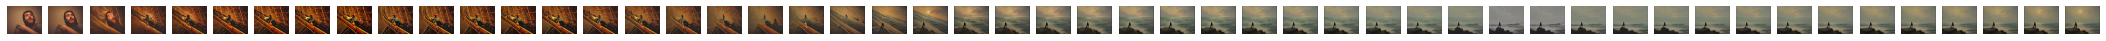

In [68]:
plt.figure(figsize=(37.5, 20))
for i in range(len(stills)):
    ax = plt.subplot(1, len(stills), i + 1)
    plt.imshow(stills[i])
    plt.axis("off")

In [73]:
f, ax = plt.subplots(nrows=10, ncols=10, figsize=(25, 20), tight_layout=True)

for i in range(10):
  for j in range(10):
    idx = i * 10 + j
    ax[i][j].imshow(stills[idx])
    ax[i][j].axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [74]:
export_as_gif(filename='showcase1.gif', images=stills, frames_per_second=5)

In [76]:
# IImage('showcase1.gif')

In [77]:
import random

In [81]:
gif_length = 100
indices = list(range(1170-gif_length))
rand_indices = []
for i in range(6):
  idx = random.choice(indices)
  stills = []
  for j in range(idx, idx+gif_length):
    stills.append(Image.open(path + f'/img_{j}.png'))
  export_as_gif(filename=f'showcase_rand_{i}.gif', images=stills, frames_per_second=5)

In [84]:
# IImage('showcase_rand_2.gif')

In [85]:
from google.colab import files

In [88]:
files.download('showcase_rand_4.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
files.download('showcase_rand_5.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>